## Deksripsi Projek

**Deskripsi Topik**

Dataset yang tersedia berisi data tentang penggunaan layanan telepon virtual "CallMeMaybe". Para kliennya adalah perusahaan-perusahaan yang perlu mendistribusikan panggilan masuk dalam jumlah besar di antara sejumlah operator, atau melakukan panggilan keluar melalui operator mereka. Operator tersebut juga bisa melakukan panggilan internal untuk berkomunikasi satu sama lain.

**Tujuan**

Memberikan informasi kepada para supervisor terkait **operator mana yang paling tidak efektif**. 

Seorang operator dianggap tidak efektif jika: 
1. dia memiliki banyak panggilan masuk yang tidak terjawab (baik internal maupun eksternal)
2. waktu tunggu yang lama untuk panggilan masuk. 
3. Apabila seorang operator diharapkan untuk melakukan panggilan keluar, kecilnya jumlah panggilan juga merupakan tanda bahwa operator tersebut tidak efektif.


Terdapat 2 dataset yang nantinya akan digunakan untuk analisa

1. telecom_dataset_us.csv:
 - user_id — ID akun pelanggan
 - date — tanggal data statistik ini diambil
 - direction — arah panggilan (out untuk panggilan keluar, in untuk panggilan masuk)
 - internal — apakah panggilan tersebut internal (berlangung di antara para operator klien)
 - operator_id — ID operator 
 - is_missed_call — apakah panggilan tidak terjawab
 - calls_count — jumlah panggilan
 - call_duration — durasi panggilan (tidak termasuk waktu tunggu) 
 - total_call_duration — durasi panggilan (termasuk waktu tunggu)



2. telecom_clients_us.csv:
 - user_id
 - tariff_plan — paket klien saat ini
 - date_start — tanggal klien melakukan pendaftaran

# Operator Tidak Efektif

## Inisiasi

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

## Optimalisasi Data

In [5]:
client = pd.read_csv('datasets/telecom_clients_us.csv',
                     parse_dates=['date_start'],
                     dtype={'tariff_plan' : 'category'})
client.sample(10)

,user_id,tariff_plan,date_start
580,166428,B,2019-08-02
168,168336,C,2019-10-22
567,167995,B,2019-10-09
716,167697,B,2019-09-25
25,168049,A,2019-10-10
512,168513,B,2019-10-29
555,168154,B,2019-10-15
707,167551,B,2019-09-20
554,168066,B,2019-10-11
685,167543,B,2019-09-19


In [6]:
client.duplicated().sum()

0

In [7]:
dataset = pd.read_csv('datasets/telecom_dataset_us.csv',
                      parse_dates=['date'],
                      dtype={'direction' : 'category'})
dataset.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
23644,167109,2019-09-10 00:00:00+03:00,in,False,907178.0,False,2,185,231
9729,166658,2019-11-18 00:00:00+03:00,out,False,890404.0,False,21,4225,4494
17467,166939,2019-11-15 00:00:00+03:00,in,False,NaN,True,5,0,77
50704,168252,2019-11-21 00:00:00+03:00,out,False,940616.0,False,42,1494,2195
38723,167654,2019-10-11 00:00:00+03:00,out,False,918986.0,True,3,0,63
43257,167977,2019-11-25 00:00:00+03:00,in,False,NaN,True,1,0,2
15838,166901,2019-10-22 00:00:00+03:00,out,True,896008.0,True,1,0,19
53406,168412,2019-11-25 00:00:00+03:00,out,False,953460.0,True,2,0,0
4676,166511,2019-10-02 00:00:00+03:00,out,True,891410.0,True,5,0,3
2192,166406,2019-11-18 00:00:00+03:00,out,False,879898.0,False,66,3617,4388


In [8]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  category                 
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: bool(1), category(1), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(1)
memory usage: 4.4 MB


In [9]:
dataset.duplicated().sum()

4900

Terdapat Data yang hilang pada `operator_id` dan `internal`, selain itu dataset juga terdapat nilai duplikat sebanyak 4900 data. Data yang hilang pada `operator_id` dan `internal` tidak dapat diisi dengan sembarangan nilai, maka dari itu sebaiknya data yang hilang tersebut dapat dihilangkan agar tidak menganggu jalannya analisa data.

## Pembersihan Data

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
dataset.duplicated().sum()

0

In [12]:
dataset_isna = dataset[dataset['operator_id'].isna() | dataset['internal'].isna()]

In [13]:
dataset_isna['call_duration'].value_counts()

call_duration
0      7343
81        3
90        3
5         3
229       2
       ... 
44        1
109       1
136       1
124       1
169       1
Name: count, Length: 148, dtype: int64

Alasan mengapa nilai menjadi NA masih belum diketahui. Kemungkinan besar kesalahan dari sistem sehingga ID operator tidak tercantumkan

In [14]:
dataset_isna.shape[0] / dataset.shape[0] * 100

15.327945798130688

Data yang hilang berjumlah 15 % dari data asli, Secara teori, data hilang yang diperbolehkan untuk di `drop` dapat bernilai 25% hingga 30%. https://www.analyticsvidhya.com/blog/2022/03/exploratory-data-analysis-eda-credit-card-fraud-detection-case-study/ 

In [15]:
dataset_filtered = dataset.dropna().reset_index().drop('index',axis=1)
dataset_filtered

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
1,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
3,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
4,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09 00:00:00+03:00,out,False,957922.0,False,4,551,593
41487,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25
41488,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
41489,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501


In [16]:
dataset_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              41491 non-null  int64                    
 1   date                 41491 non-null  datetime64[ns, UTC+03:00]
 2   direction            41491 non-null  category                 
 3   internal             41491 non-null  object                   
 4   operator_id          41491 non-null  float64                  
 5   is_missed_call       41491 non-null  bool                     
 6   calls_count          41491 non-null  int64                    
 7   call_duration        41491 non-null  int64                    
 8   total_call_duration  41491 non-null  int64                    
dtypes: bool(1), category(1), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(1)
memory usage: 2.3+ MB


Data sudah bersih dan siap dipakai untuk analisa lebih lanjut.

## Analisa Awal

Seorang operator dianggap tidak efektif jika: 
1. dia memiliki banyak panggilan masuk yang tidak terjawab (baik internal maupun eksternal)
2. waktu tunggu yang lama untuk panggilan masuk. 
3. Apabila seorang operator diharapkan untuk melakukan panggilan keluar, kecilnya jumlah panggilan juga merupakan tanda bahwa operator tersebut tidak efektif.

In [17]:
dataset_filtered['operator_id'].value_counts()

operator_id
901884.0    323
901880.0    300
893804.0    289
885876.0    283
887276.0    267
           ... 
905082.0      1
919958.0      1
969284.0      1
911104.0      1
948282.0      1
Name: count, Length: 1092, dtype: int64

In [18]:
data_combine = dataset_filtered.merge(client, how='left', on='user_id')

In [19]:
data_combine

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09 00:00:00+03:00,out,False,957922.0,False,4,551,593,C,2019-10-31
41487,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25,C,2019-10-31
41488,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38,C,2019-10-31
41489,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501,C,2019-10-31


In [20]:
data_combine['operator_id'] = data_combine['operator_id'].astype('int')

In [21]:
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              41491 non-null  int64                    
 1   date                 41491 non-null  datetime64[ns, UTC+03:00]
 2   direction            41491 non-null  category                 
 3   internal             41491 non-null  object                   
 4   operator_id          41491 non-null  int32                    
 5   is_missed_call       41491 non-null  bool                     
 6   calls_count          41491 non-null  int64                    
 7   call_duration        41491 non-null  int64                    
 8   total_call_duration  41491 non-null  int64                    
 9   tariff_plan          41491 non-null  category                 
 10  date_start           41491 non-null  datetime64[ns]           
dtypes:

In [22]:
data_combine.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,date_start
count,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491
mean,167301.113543,916516.771155,16.921381,1010.940011,1323.153238,2019-09-09 06:50:24.135354624
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,2019-08-01 00:00:00
25%,166782.000000,900790.000000,1.000000,0.000000,67.000000,2019-08-19 00:00:00
50%,167175.000000,913938.000000,4.000000,106.000000,289.000000,2019-09-05 00:00:00
75%,167827.000000,937708.000000,14.000000,772.000000,1107.000000,2019-10-02 00:00:00
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,2019-10-31 00:00:00
std,600.513986,21234.081589,59.786187,4066.666485,4788.953155,NaN


In [23]:
print('Tanggal dataset berawal dari tanggal {}, dan berakhir di tanggal {}'.format(data_combine['date'].dt.date.min(),data_combine['date'].dt.date.max()))

Tanggal dataset berawal dari tanggal 2019-08-02, dan berakhir di tanggal 2019-11-28


Empat bulan data yang akan dianalisa.

### Jumlah Panggilan Keluar Operator

In [24]:
operator_out_count_temp = data_combine[(data_combine['direction'] == 'out') & (data_combine['internal'] == False)].groupby('operator_id',as_index=False).agg({
    "user_id": "count"
})
temp = data_combine.groupby('operator_id',as_index=False).agg({
    "user_id": "count"
})
operator_out_count_temp.columns = ['operator_id','total_out_call']
operator_out_count = operator_out_count_temp.merge(temp, how='right', on='operator_id')
operator_out_count.columns = ['operator_id','total_out_call','total_call']
operator_out_count['percentage_out_call'] = operator_out_count['total_out_call'] / operator_out_count['total_call'] * 100
operator_out_count = operator_out_count.fillna(0)
operator_out_count.sort_values(['total_out_call', 'percentage_out_call'], ascending=False)


,operator_id,total_out_call,total_call,percentage_out_call
28,885876,191.0,283,67.491166
203,901880,168.0,300,56.000000
204,901884,167.0,323,51.702786
48,889410,162.0,242,66.942149
29,885890,159.0,253,62.845850
...,...,...,...,...
1071,969380,0.0,2,0.000000
1083,971100,0.0,2,0.000000
1084,971102,0.0,4,0.000000
1085,971354,0.0,2,0.000000


In [25]:
operator_out_count['percentage_out_call'].describe()

count    1092.000000
mean       49.940473
std        36.909673
min         0.000000
25%         7.142857
50%        54.669988
75%        83.430233
max       100.000000
Name: percentage_out_call, dtype: float64

Rata-rata operator melakukan panggilan keluar sebanyak 32 kali dalam 4 bulan tersebut, paling sedikit 1 panggilan, dan paling banyak 228 panggilan. Namun median dari jumalah panggilan setiap operator sebanyak 19 kali, hal ini disebabkan oleh `outlier` pada jumlah panggilan sebanyak 228 yang menyebabkan nilai rata-rata bergeser ke arah tersebut. Disini akan digunakan nilai median untuk mencari tahu performa operator dibawah rata-rata.

In [26]:
operator_out_count[operator_out_count['total_out_call'] < 19 ].sort_values('total_out_call', ascending=False)

,operator_id,total_out_call,total_call,percentage_out_call
1025,960620,18.0,28,64.285714
293,907440,18.0,83,21.686747
502,921594,18.0,18,100.000000
425,919126,18.0,20,90.000000
236,904044,18.0,60,30.000000
...,...,...,...,...
558,927070,0.0,20,0.000000
553,926214,0.0,1,0.000000
548,925808,0.0,9,0.000000
546,925106,0.0,15,0.000000


Dari 882 operator, ternyata ada sekitar 437 operator dengan jumlah panggilan dibawah rata-rata.

### Panggilan Masuk yang tidak terjawab Operator

In [27]:
temp1 = data_combine[(data_combine['direction'] == 'in') & (data_combine['is_missed_call'] == True)].groupby(['operator_id'], as_index=False).agg({
    'user_id' : 'count'
})
temp1.columns = ['operator_id','missed_call_count']

temp2 = data_combine[data_combine['direction'] == 'in'].groupby(['operator_id'], as_index=False).agg({
    'user_id' : 'count'
})
temp2.columns = ['operator_id','total_in_call']

temp3 = data_combine.groupby(['operator_id'], as_index=False).agg({
    'user_id' : 'count'
})
temp3.columns = ['operator_id','total_call']

operator_missed_call_temp = temp1.merge(temp2, how='right', on='operator_id')
operator_missed_call = operator_missed_call_temp.merge(temp3, how='right', on='operator_id')
operator_missed_call = operator_missed_call.fillna(0)
operator_missed_call['percentage_missed_call'] = operator_missed_call['missed_call_count'] / operator_missed_call['total_in_call'] *100
operator_missed_call = operator_missed_call.fillna(0)
operator_missed_call = operator_missed_call.drop('total_call',axis=1)
operator_missed_call.sort_values(['missed_call_count','percentage_missed_call'], ascending=False)

,operator_id,missed_call_count,total_in_call,percentage_missed_call
369,913942,28.0,85.0,32.941176
29,885890,21.0,94.0,22.340426
28,885876,17.0,90.0,18.888889
819,944216,16.0,51.0,31.372549
779,940588,15.0,52.0,28.846154
...,...,...,...,...
1087,972410,0.0,0.0,0.000000
1088,972412,0.0,1.0,0.000000
1089,972460,0.0,1.0,0.000000
1090,973120,0.0,0.0,0.000000


Catatan terburuk memiliki panggilan tidak terjawab sebanyak 28 kali dari 85 panggilan masuk, sehingga menyebabkan persentase panggilan tidak terjawab sebesar 32.9%

### Waktu tunggu panggilan masuk

In [28]:
data_combine['wait_time'] =  data_combine['total_call_duration'] - data_combine['call_duration']
operator_wait_time = data_combine[(data_combine['is_missed_call'] ==  False) & (data_combine['direction'] == 'in')].groupby('operator_id', as_index=False).agg({
    'wait_time':'mean'
})
operator_wait_time.sort_values('wait_time', ascending=False)

,operator_id,wait_time
337,919794,1039.322581
206,906070,1018.384615
328,919204,928.100000
335,919790,894.830508
445,931458,875.725000
...,...,...
404,926872,1.333333
676,952982,1.166667
674,952954,1.000000
643,949420,1.000000


rata-rata waktu menunggu terlama yang dialami pelanggan selama 1039.322581 detik.

### Analisa Gabungan

In [29]:
temp4 = operator_wait_time.merge(operator_missed_call, how='right', on='operator_id')

combine = temp4.merge(operator_out_count, how='left', on='operator_id')
combine = combine.fillna(0)
combine.sample(10)

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call
293,907440,23.833333,0.0,6.0,0.000000,18.0,83,21.686747
142,896428,23.625000,0.0,8.0,0.000000,29.0,39,74.358974
716,937874,32.800000,1.0,6.0,16.666667,10.0,16,62.500000
385,914440,30.888889,1.0,19.0,5.263158,0.0,20,0.000000
566,928142,13.714286,0.0,7.0,0.000000,0.0,7,0.000000
371,914036,0.000000,0.0,0.0,0.000000,2.0,3,66.666667
922,950634,13.750000,0.0,8.0,0.000000,0.0,8,0.000000
678,937374,55.937500,0.0,16.0,0.000000,0.0,16,0.000000
133,896012,24.016393,1.0,62.0,1.612903,0.0,62,0.000000
980,954810,30.545455,0.0,11.0,0.000000,0.0,11,0.000000


In [30]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   operator_id             1092 non-null   int32  
 1   wait_time               1092 non-null   float64
 2   missed_call_count       1092 non-null   float64
 3   total_in_call           1092 non-null   float64
 4   percentage_missed_call  1092 non-null   float64
 5   total_out_call          1092 non-null   float64
 6   total_call              1092 non-null   int64  
 7   percentage_out_call     1092 non-null   float64
dtypes: float64(6), int32(1), int64(1)
memory usage: 64.1 KB


In [31]:
data_combine['direction'].value_counts()

direction
out    28813
in     12678
Name: count, dtype: int64

In [32]:
combine[combine['total_call'] >= 14]

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call
0,879896,27.333333,0.0,21.0,0.0,81.0,117,69.230769
1,879898,29.875000,0.0,56.0,0.0,155.0,226,68.584071
2,880020,7.714286,0.0,7.0,0.0,10.0,20,50.000000
3,880022,14.000000,0.0,8.0,0.0,54.0,70,77.142857
4,880026,7.944444,0.0,18.0,0.0,151.0,182,82.967033
...,...,...,...,...,...,...,...,...
1055,966158,15.000000,0.0,3.0,0.0,8.0,17,47.058824
1058,967310,8.000000,0.0,1.0,0.0,10.0,14,71.428571
1059,968150,2.000000,0.0,2.0,0.0,12.0,14,85.714286
1061,968338,19.166667,0.0,6.0,0.0,13.0,19,68.421053


In [33]:
data_combine[data_combine['operator_id'] == 880026].groupby(['is_missed_call','direction'])['operator_id'].count()

C:\Users\User_Asus\AppData\Local\Temp\ipykernel_2188\2120760342.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_combine[data_combine['operator_id'] == 880026].groupby(['is_missed_call','direction'])['operator_id'].count()


is_missed_call  direction
False           in           18
                out          77
True            in            0
                out          87
Name: operator_id, dtype: int64

Berdasarkan salah satu contoh, data NaN disini memiliki arti bahwa operator masih belum banyak penglaman / belum pernah mendapat kasus dimana operator melakukan panggilan tidak terjawab dengan sehingga dapat di ubah nilainya menjadi 0.

In [34]:
#combine.dropna(inplace=True)
#combine.reset_index(drop=True, inplace=True)
combine = combine.fillna(0)
combine['operator_id'] = combine['operator_id'].astype('int')
combine['missed_call_count'] = combine['missed_call_count'].astype('int')
combine['total_in_call'] = combine['total_in_call'].astype('int')
combine['total_out_call'] = combine['total_out_call'].astype('int')
combine['total_call'] = combine['total_call'].astype('int')
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   operator_id             1092 non-null   int32  
 1   wait_time               1092 non-null   float64
 2   missed_call_count       1092 non-null   int32  
 3   total_in_call           1092 non-null   int32  
 4   percentage_missed_call  1092 non-null   float64
 5   total_out_call          1092 non-null   int32  
 6   total_call              1092 non-null   int32  
 7   percentage_out_call     1092 non-null   float64
dtypes: float64(3), int32(5)
memory usage: 47.1 KB


In [35]:
combine.describe()

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,925517.543956,43.003811,0.626374,11.609890,2.573927,21.858059,37.995421,49.940473
std,22854.532209,96.300550,2.041180,18.100944,7.244503,31.785933,49.141679,36.909673
min,879896.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,906393.500000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,7.142857
50%,925105.000000,19.000000,0.000000,3.000000,0.000000,7.500000,19.000000,54.669988
75%,944211.500000,44.000000,0.000000,15.000000,0.000000,32.000000,50.000000,83.430233
max,973286.000000,1039.322581,28.000000,107.000000,100.000000,191.000000,323.000000,100.000000


Pada deskripsi, hal pertama yang harus kita lihat adalah kolom `total_call` yang mana memiliki arti tidak setiap operator sudah mendapat banyak panggilan, bisa jadi terdapat operator yang masih baru dan tidak dapat di tandai karena 'kurang'. Sehingga disini hanya operator yang telah mendapatkan panggilan lebih dari 50% persentilnya, juga dapat dibuktikan dengan histogram sebagai berikut.

array([[<Axes: title={'center': 'total_call'}>]], dtype=object)

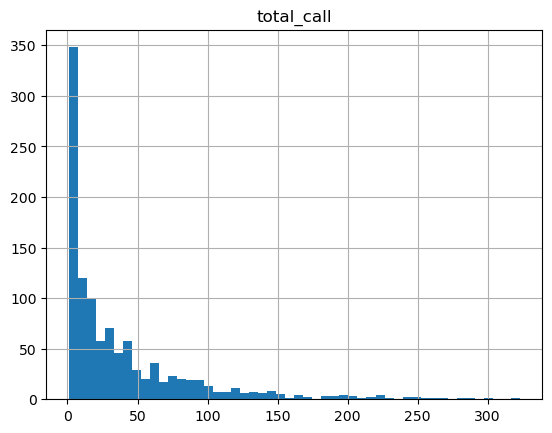

In [36]:
combine.hist('total_call', bins=50)

In [37]:
combine[(combine['total_call'] < 19)].sample(20)

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call
874,946454,0.000000,0,0,0.000000,2,2,100.000000
374,914168,11.000000,0,1,0.000000,5,6,83.333333
1030,960674,0.000000,0,0,0.000000,0,1,0.000000
535,924936,25.400000,1,6,16.666667,0,6,0.000000
45,888538,24.000000,0,1,0.000000,2,6,33.333333
1070,969294,177.500000,0,4,0.000000,4,10,40.000000
208,901996,43.000000,0,1,0.000000,3,5,60.000000
122,895370,0.000000,0,0,0.000000,2,2,100.000000
388,914636,14.000000,0,2,0.000000,7,11,63.636364
1071,969380,21.000000,0,1,0.000000,0,2,0.000000


Banyak yang masih belum memiliki cukup panggilan untuk dapat dievaluasi lebih lanjut.

In [38]:
combine = combine[(combine['total_call'] > 19)]
combine.describe()

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,921543.732342,63.307581,1.171004,20.490706,3.650469,41.308550,70.159851,59.130708
std,21013.783221,124.644581,2.771317,22.188479,7.798406,35.890346,53.239144,29.935281
min,879896.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000
25%,904039.500000,0.000000,0.000000,0.000000,0.000000,17.250000,33.000000,42.060407
50%,920541.000000,29.529412,0.000000,14.000000,0.000000,32.000000,51.000000,62.500000
75%,939475.500000,60.755147,1.000000,33.000000,4.496047,55.750000,88.750000,83.532456
max,969272.000000,1039.322581,28.000000,107.000000,100.000000,191.000000,323.000000,100.000000


## Klasterisasi Operator

In [39]:
operator = combine.drop(['operator_id','percentage_missed_call','percentage_out_call'], axis=1)
operator.head(10)

,wait_time,missed_call_count,total_in_call,total_out_call,total_call
0,27.333333,0,21,81,117
1,29.875000,0,56,155,226
2,7.714286,0,7,10,20
3,14.000000,0,8,54,70
4,7.944444,0,18,151,182
5,8.365854,0,41,154,202
10,37.450000,3,43,0,43
11,205.652174,4,50,101,154
12,177.777778,5,68,150,224
14,349.100000,2,22,40,63


Kita coba menggunakan K-means dengan terlebih dahulu mencari asumsi awal jumlah kelompok yang memungkinkan menggunakan dendrogram

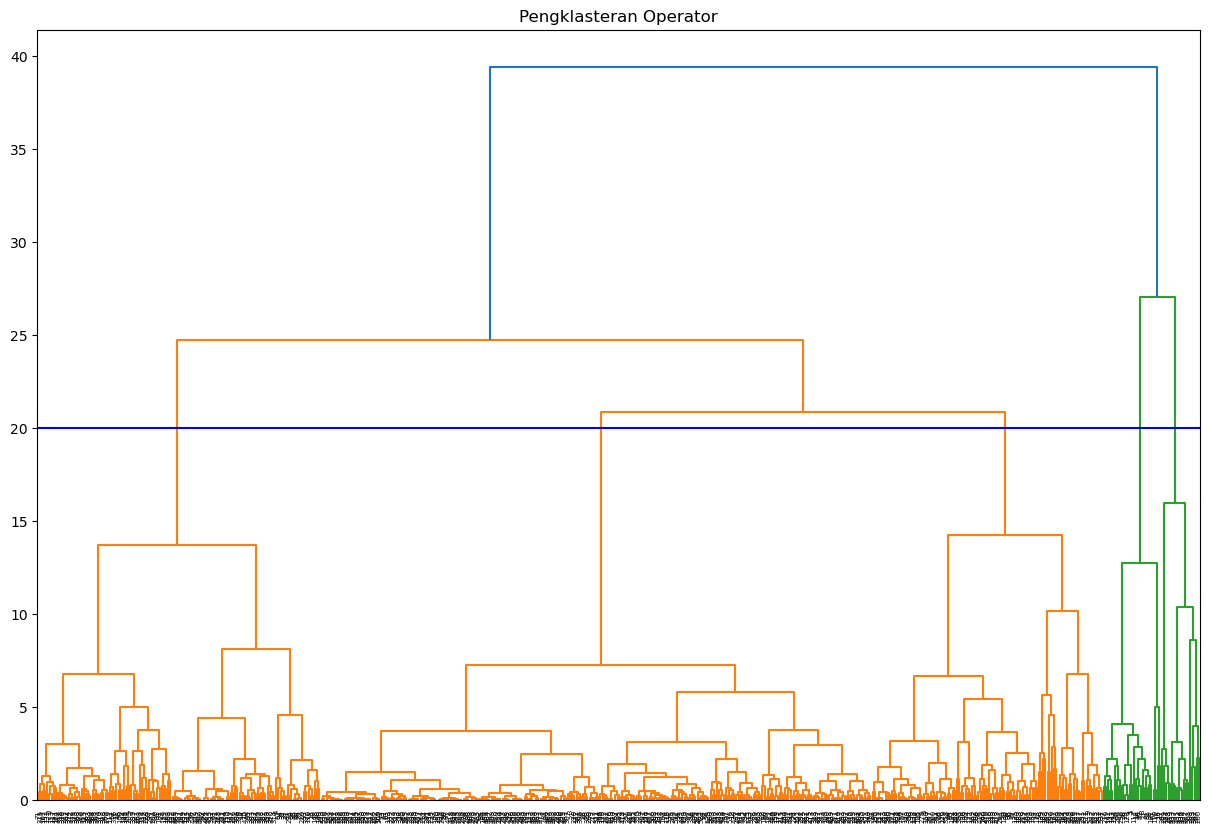

In [40]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(operator)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y = 20, color = 'b', linestyle = '-') 
plt.title('Pengklasteran Operator')
plt.show()

Disini nilai yang baik adalah K yang bernilai kecil antara 4 atau 5, tetapi karena terdapat kluster yang berdekatan, akan digabungkan menjadi satu kluster saja, sehungga kita menggunakan K = 4.

In [41]:
km = KMeans(n_clusters = 4)
labels = km.fit_predict(X_sc)

combine['labels'] = labels
operator['labels'] = labels
operator.groupby('labels').mean()

C:\Users\User_Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User_Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,wait_time,missed_call_count,total_in_call,total_out_call,total_call
labels,,,,,
0,442.329448,7.580645,43.516129,34.580645,86.580645
1,26.134258,0.283133,8.924699,24.683735,40.259036
2,59.580672,1.264286,30.635714,59.300000,100.550000
3,95.125657,3.542857,69.228571,133.000000,217.685714


In [42]:
silhouette_score(X_sc, labels)

0.4041864329811797

Skor dari Kluster masih sangat bagus, sehingga pengelompokan masih dapat diterima.
Dari label, diketahui bahwa operator dengan label terburuk, yaitu operator dengan persentase panggilan masuk tidak terjawab, persentase panggilan keluar, dan tunggu panggilan yang lama. Disini nilai dari persentase panggilan masuk tidak terjawab akan sangat besar karena berpengaruh langsung dengan loyalitas pelanggan, diikuti dengan waktu tunggu, dan persentase pangggilan keluar. 

nantinya setiap label akan diberi 5 nama label utama bergantung pada performa yang diberikan,
1. Buruk
3. Netral
4. Baik
5. Sangat Baik

Disini label yang dinilai tidak baik / memiliki performa yang buruk karena nilai waktu tunggu yang sangat besar, berbarengan dengan waktu masuk tidak terjawab yang juga cukup besar memiliki performa yang sangat buruk. Maka dari itu, sebaiknya operator dengan label tersebut di latih kembali, atau di beri sangsi.

# Analisa Akhir

Uniknya, berdasarkan analisa yang didapat, biasanya label dengan persentase panggilan masuk tidak terjawab banyak juga memiliki rata-rata `wait_time` berdasarkan label terbesar diantara ketiga lainnya. Lakukan juga untuk label dengan `percentage_out_call`.

In [43]:
label_wait_time = combine.groupby('labels', as_index=False)['wait_time'].mean()
label_wait_time.columns = ['labels', 'wait_time_mean']
label_wait_time

,labels,wait_time_mean
0,0,442.329448
1,1,26.134258
2,2,59.580672
3,3,95.125657


In [44]:
label_per_out_call = combine.groupby('labels', as_index=False)['percentage_out_call'].mean()
label_per_out_call.columns = ['labels', 'percentage_out_call_mean']
label_per_out_call

,labels,percentage_out_call_mean
0,0,38.151339
1,1,61.568719
2,2,57.412339
3,3,61.459633


In [45]:
bad_operator_temp = combine.merge(label_wait_time, how = 'left', on='labels')
bad_operator_temp = bad_operator_temp.merge(label_per_out_call, how='left', on='labels')
bad_operator_1 = bad_operator_temp[bad_operator_temp['wait_time_mean'] == label_wait_time['wait_time_mean'].max()]
bad_operator_1

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
9,882690,349.100000,2,22,9.090909,40,63,63.492063,0,442.329448,38.151339
154,906070,1018.384615,2,15,13.333333,22,37,59.459459,0,442.329448,38.151339
162,906404,360.891892,6,43,13.953488,65,154,42.207792,0,442.329448,38.151339
163,906406,451.809524,3,45,6.666667,82,202,40.594059,0,442.329448,38.151339
164,906408,278.625000,4,28,14.285714,6,61,9.836066,0,442.329448,38.151339
165,906410,201.724138,5,34,14.705882,11,47,23.404255,0,442.329448,38.151339
187,908958,287.777778,3,93,3.225806,42,142,29.577465,0,442.329448,38.151339
207,913938,631.453125,13,77,16.883117,69,148,46.621622,0,442.329448,38.151339
208,913942,505.140351,28,85,32.941176,43,135,31.851852,0,442.329448,38.151339
231,919164,442.444444,3,12,25.000000,8,20,40.000000,0,442.329448,38.151339


In [46]:
bad_operator_1.describe()

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0,3.100000e+01,3.100000e+01
mean,925541.870968,442.329448,7.580645,43.516129,18.670759,34.580645,86.580645,38.151339,0.0,4.423294e+02,3.815134e+01
std,17799.312286,277.102620,6.015392,21.183124,10.641765,24.491868,43.752161,15.989909,0.0,1.155661e-13,2.166864e-14
min,882690.000000,143.631579,0.000000,12.000000,0.000000,6.000000,20.000000,7.228916,0.0,4.423294e+02,3.815134e+01
25%,913940.000000,217.373400,3.000000,28.000000,12.549020,11.000000,60.000000,26.693494,0.0,4.423294e+02,3.815134e+01
50%,919792.000000,360.891892,6.000000,45.000000,20.000000,38.000000,83.000000,40.594059,0.0,4.423294e+02,3.815134e+01
75%,942423.000000,588.732267,11.000000,51.500000,28.285714,47.500000,104.000000,49.122807,0.0,4.423294e+02,3.815134e+01
max,958460.000000,1039.322581,28.000000,93.000000,35.714286,87.000000,202.000000,63.492063,0.0,4.423294e+02,3.815134e+01


Disini akan di bersihkan berdasarkan panggilan tidak terjawab, karena hal tersebut sangat mempengaruhi loyalitas customer, nilainya persentasenya harus lebih besar dari 75% persentil data awal pada dataframe `combine`.

In [47]:
bad_operator = bad_operator_1[bad_operator_1['percentage_missed_call'] > np.percentile(combine['percentage_missed_call'],75)]
bad_operator

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
9,882690,349.100000,2,22,9.090909,40,63,63.492063,0,442.329448,38.151339
154,906070,1018.384615,2,15,13.333333,22,37,59.459459,0,442.329448,38.151339
162,906404,360.891892,6,43,13.953488,65,154,42.207792,0,442.329448,38.151339
163,906406,451.809524,3,45,6.666667,82,202,40.594059,0,442.329448,38.151339
164,906408,278.625000,4,28,14.285714,6,61,9.836066,0,442.329448,38.151339
165,906410,201.724138,5,34,14.705882,11,47,23.404255,0,442.329448,38.151339
207,913938,631.453125,13,77,16.883117,69,148,46.621622,0,442.329448,38.151339
208,913942,505.140351,28,85,32.941176,43,135,31.851852,0,442.329448,38.151339
231,919164,442.444444,3,12,25.000000,8,20,40.000000,0,442.329448,38.151339
232,919166,558.200000,4,14,28.571429,10,24,41.666667,0,442.329448,38.151339


In [48]:
bad_operator.shape[0]

26

Kemudian operator yang secara visual dari rata-rata data buruk dapat kita bandingkan dengan salah satu kelompok operator dengan nilai rata-rata waktu tunggu dan panggilan masuk tidak terjawab terlama dan terbanyak kedua setelahnya. 

In [49]:
operator_2 = bad_operator_temp[bad_operator_temp['wait_time_mean'] == label_wait_time['wait_time_mean'].sort_values(ascending=False,ignore_index=True)[1]]
operator_2

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
1,879898,29.875000,0,56,0.000000,155,226,68.584071,3,95.125657,61.459633
4,880026,7.944444,0,18,0.000000,151,182,82.967033,3,95.125657,61.459633
5,880028,8.365854,0,41,0.000000,154,202,76.237624,3,95.125657,61.459633
7,882684,205.652174,4,50,8.000000,101,154,65.584416,3,95.125657,61.459633
8,882686,177.777778,5,68,7.352941,150,224,66.964286,3,95.125657,61.459633
16,885876,120.301370,17,90,18.888889,191,283,67.491166,3,95.125657,61.459633
17,885890,151.301370,21,94,22.340426,159,253,62.845850,3,95.125657,61.459633
18,887276,182.651515,3,69,4.347826,125,267,46.816479,3,95.125657,61.459633
26,889410,35.151899,0,79,0.000000,162,242,66.942149,3,95.125657,61.459633
27,889754,54.142857,2,72,2.777778,126,199,63.316583,3,95.125657,61.459633


In [50]:
operator_2.describe()

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.0,3.500000e+01,3.500000e+01
mean,897400.800000,95.125657,3.542857,69.228571,4.437284,133.000000,217.685714,61.459633,3.0,9.512566e+01,6.145963e+01
std,12395.528769,69.011067,4.773350,19.442352,5.209952,27.114138,42.586087,9.160762,0.0,4.325497e-14,1.441832e-14
min,879898.000000,7.944444,0.000000,18.000000,0.000000,50.000000,154.000000,31.645570,3.0,9.512566e+01,6.145963e+01
25%,889582.000000,46.105595,0.000000,57.500000,0.000000,114.500000,186.000000,56.352490,3.0,9.512566e+01,6.145963e+01
50%,893804.000000,76.150685,2.000000,69.000000,3.030303,135.000000,216.000000,62.845850,3.0,9.512566e+01,6.145963e+01
75%,903678.000000,127.146459,4.000000,78.500000,5.976190,151.000000,245.500000,66.430549,3.0,9.512566e+01,6.145963e+01
max,925104.000000,312.983333,21.000000,107.000000,22.340426,191.000000,323.000000,82.967033,3.0,9.512566e+01,6.145963e+01


Data kedua tidak harus dibersikan.

In [51]:
label_per_out_call['percentage_out_call_mean'].sort_values(ignore_index=True)

0    38.151339
1    57.412339
2    61.459633
3    61.568719
Name: percentage_out_call_mean, dtype: float64

In [52]:
operator_3 = bad_operator_temp[bad_operator_temp['percentage_out_call_mean'] == label_per_out_call['percentage_out_call_mean'].sort_values(ignore_index=True)[1]]
operator_3

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
0,879896,27.333333,0,21,0.000000,81,117,69.230769,2,59.580672,57.412339
11,883942,15.514286,0,35,0.000000,113,149,75.838926,2,59.580672,57.412339
13,884412,46.875000,0,16,0.000000,90,113,79.646018,2,59.580672,57.412339
14,884478,26.916667,0,12,0.000000,70,85,82.352941,2,59.580672,57.412339
15,884946,22.714286,0,7,0.000000,73,82,89.024390,2,59.580672,57.412339
...,...,...,...,...,...,...,...,...,...,...,...
427,940658,137.066667,6,36,16.666667,42,83,50.602410,2,59.580672,57.412339
430,941384,23.125000,0,24,0.000000,61,86,70.930233,2,59.580672,57.412339
440,944646,88.913043,1,24,4.166667,44,72,61.111111,2,59.580672,57.412339
492,948182,56.520000,0,25,0.000000,48,75,64.000000,2,59.580672,57.412339


## Perbedaan Statistika Label

### Persentase Panggilan tidak terjawab

In [53]:
alpha = .05# ketik kode programmu di sini

results = st.mannwhitneyu(operator_2['percentage_missed_call'], bad_operator['percentage_missed_call'], True, 'less')# ketik kode programmu di sini

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan")
else:
    print("Gagal menolak hipotesis nol: kita tidak bisa menyimpulkan perbedaannya")

p-value:  3.0088043635027063e-10
Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan


Kedua data memiliki persentase panggilan masuk yang tidak terjawab kurang lebih sama.

### Waktu Tunggu

In [54]:
alpha = .05# ketik kode programmu di sini

results = st.mannwhitneyu(operator_2['wait_time'], bad_operator['wait_time'], True, 'less')# ketik kode programmu di sini

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan")
else:
    print("Gagal menolak hipotesis nol: kita tidak bisa menyimpulkan perbedaannya")

p-value:  8.946468058848376e-10
Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan


Untuk waktu tunggu, sudah jelas, kelompok pertama lebih `buruk` daripada kelompok 2.

### Persentase Panggilan Keluar

In [55]:
alpha = .05# ketik kode programmu di sini

results = st.mannwhitneyu(operator_3['percentage_out_call'], bad_operator['percentage_out_call'], True, 'greater')# ketik kode programmu di sini

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan")
else:
    print("Gagal menolak hipotesis nol: kita tidak bisa menyimpulkan perbedaannya")

p-value:  1.939476030985502e-05
Hipotesis nol ditolak: perbedaannya secara statistik sangat signifikan


Tidak bisa menyimpulkan perbedaannya, dengan kata lain keduanya memiliki persentase operator yang jarang melakukan panggilan keluar yang sama.

# Kesimpulan

Karena dari ketiga faktor, kelompok yang memiliki nilai yang lebih `buruk` dari kelompok lainnya didasarkan pada sedikitnya panggilan keluar, panggilan tidak terjawab, dan waktu tunggunya, dengan kata lain operator memiliki kecenderungan untuk menunda pengangkatan telepon yang lama sehingga menyebabkan penggilan tidak terjawab semakin banyak dan tidak proaktif untuk melakukan panggilan keluar, atau nilai `wait_time`, `Persentage_missed_call`, yang tinggi dan `percentage_out_call` yang rendah dapat memprediksi kinerja yang `sangat buruk` pada seorang operator. Operator tersebut ditampilkan dibawah ini.

In [56]:
bad_operator.sort_values('missed_call_count', ascending=False)

,operator_id,wait_time,missed_call_count,total_in_call,percentage_missed_call,total_out_call,total_call,percentage_out_call,labels,wait_time_mean,percentage_out_call_mean
208,913942,505.140351,28,85,32.941176,43,135,31.851852,0,442.329448,38.151339
433,944216,201.628571,16,51,31.372549,37,88,42.045455,0,442.329448,38.151339
419,940588,175.837838,15,52,28.846154,14,68,20.588235,0,442.329448,38.151339
437,944226,171.888889,14,50,28.000000,38,88,43.181818,0,442.329448,38.151339
207,913938,631.453125,13,77,16.883117,69,148,46.621622,0,442.329448,38.151339
435,944220,233.243243,12,49,24.489796,55,104,52.884615,0,442.329448,38.151339
436,944222,169.303030,11,44,25.000000,51,95,53.684211,0,442.329448,38.151339
434,944218,223.378378,11,48,22.916667,42,90,46.666667,0,442.329448,38.151339
424,940630,211.368421,11,49,22.448980,8,61,13.114754,0,442.329448,38.151339
260,919554,590.734375,11,75,14.666667,6,83,7.228916,0,442.329448,38.151339


In [66]:
print(f'Terdapat {bad_operator.shape[0]} dari {combine.shape[0]} operator yang tidak efektif berdasarkan analisis')

Terdapat 26 dari 538 operator yang tidak efektif berdasarkan analisis


## Plot dari setiap Label

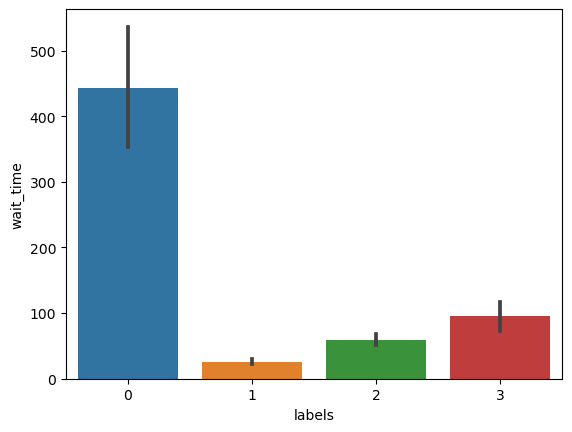

In [58]:
ax = sns.barplot(x='labels', y='wait_time', data=combine)

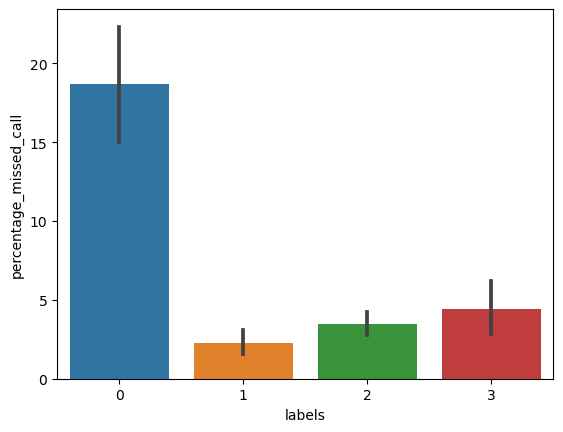

In [59]:
ax = sns.barplot(x='labels', y='percentage_missed_call', data=combine)

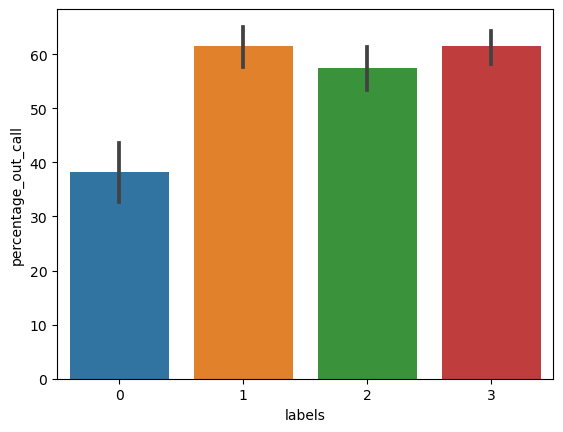

In [60]:
ax = sns.barplot(x='labels', y='percentage_out_call', data=combine)

# Link Menuju DashBoard

DashBoard = https://public.tableau.com/views/DashboardAnalisisEfektifitasOperator/Dashboard1?:language=en-US&:sid=&:display_count=n&:origin=viz_share_link